In [1]:
import sqlite3

def list_tables(db_path):
    """ Listet alle Tabellen in einer SQLite-Datenbank auf. """
    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        conn.close()
        return [table[0] for table in tables]
    except Exception as e:
        return f"Fehler: {e}"

# Pfad zur Datenbankdatei
db_path = "source_allergy.db"

tables = list_tables(db_path)
print("Tabellen in der Datenbank:", tables)

Tabellen in der Datenbank: ['disease', 'patients', 'encounters', 'careplans', 'conditions', 'medications', 'procedures', 'observations', 'devices', 'imaging_studies', 'immunizations']


In [2]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Verbindung zur SQLite-Datenbank herstellen
db_path = "source_allergy.db"
conn = sqlite3.connect(db_path)

# Patienten- und Beobachtungsdaten abrufen
patients_df = pd.read_sql_query("SELECT Id, HEALTHCARE_EXPENSES FROM patients;", conn)
bmi_values = pd.read_sql_query("SELECT PATIENT, VALUE as BMI FROM observations WHERE CODE = '39156-5';", conn)

# Verbindung schließen
conn.close()

# Daten zusammenführen
bmi_expenses_df = pd.merge(patients_df, bmi_values, left_on='Id', right_on='PATIENT', how='inner')

# Features und Zielvariable definieren
X = bmi_expenses_df[['BMI']]
y = bmi_expenses_df['HEALTHCARE_EXPENSES']

# Daten in Trainings- und Testsets aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lineares Regressionsmodell trainieren
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersagen treffen
y_pred = model.predict(X_test)

# Modellbewertung
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Ergebnisse ausgeben
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")


Mean Absolute Error: 514735.97731053917
Mean Squared Error: 380188052682.7128
Root Mean Squared Error: 616593.9122978046
R-squared Score: 0.10829326456109312


Die Ergebnisse deuten darauf hin, dass das lineare Regressionsmodell nicht besonders gut darin ist, die zukünftigen Gesundheitsausgaben basierend auf dem BMI vorherzusagen. Die R²-Score von 0.108 zeigt, dass nur ~10.8% der Varianz in den Gesundheitsausgaben durch den BMI erklärt werden kann. Zudem sind die Fehlerwerte (MAE, MSE, RMSE) sehr hoch. 

Naechster Schritt: 

Mehr Features einbeziehen: Aktuell nutzen wir nur den BMI. Weitere Faktoren wie Alter, Geschlecht, bestehende Erkrankungen, Medikationen und frühere Gesundheitskosten könnten das Modell verbessern.

Nicht-lineare Modelle ausprobieren: Gesundheitsausgaben könnten nicht-linear mit dem BMI zusammenhängen. Modelle wie Random Forest Regression, Gradient Boosting, oder Polynomial Regression könnten bessere Ergebnisse liefern.

In [3]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Verbindung zur SQLite-Datenbank herstellen
db_path = "source_allergy.db"
conn = sqlite3.connect(db_path)

# Patienten- und Beobachtungsdaten abrufen
patients_df = pd.read_sql_query("SELECT Id, HEALTHCARE_EXPENSES, HEALTHCARE_COVERAGE, BIRTHDATE FROM patients;", conn)
bmi_values = pd.read_sql_query("SELECT PATIENT, VALUE as BMI FROM observations WHERE CODE = '39156-5';", conn)
medications_count = pd.read_sql_query("SELECT PATIENT, COUNT(*) as MEDICATION_COUNT FROM medications GROUP BY PATIENT;", conn)

# Verbindung schließen
conn.close()

# Alter berechnen
patients_df['BIRTHDATE'] = pd.to_datetime(patients_df['BIRTHDATE'])
patients_df['AGE'] = (pd.to_datetime("today") - patients_df['BIRTHDATE']).dt.days // 365

# Daten zusammenführen
merged_df = patients_df.merge(bmi_values, left_on='Id', right_on='PATIENT', how='left')
merged_df = merged_df.merge(medications_count, left_on='Id', right_on='PATIENT', how='left')
merged_df.fillna({'BMI': merged_df['BMI'].median(), 'MEDICATION_COUNT': 0}, inplace=True)

# Features und Zielvariable definieren
features = ['BMI', 'HEALTHCARE_COVERAGE', 'AGE', 'MEDICATION_COUNT']
X = merged_df[features]
y = merged_df['HEALTHCARE_EXPENSES']

# Daten in Trainings- und Testsets aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lineares Regressionsmodell trainieren
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersagen treffen
y_pred = model.predict(X_test)

# Modellbewertung
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Ergebnisse ausgeben
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

Mean Absolute Error: 335023.42202000914
Mean Squared Error: 209199345583.41757
Root Mean Squared Error: 457383.14964963193
R-squared Score: 0.48608112976348516


Das Modell hat sich mit den zusätzlichen Features deutlich verbessert:

MAE reduziert von ~514K auf ~335K
MSE und RMSE haben sich verringert
R²-Score stieg von 0.108 auf 0.486, was bedeutet, dass nun ~49% der Varianz der Gesundheitsausgaben erklärt wird.

Naechster Schritt: 

Nicht-lineare Modelle testen: Die Beziehung zwischen BMI, Alter und Gesundheitskosten könnte nicht-linear sein. Ein Random Forest Regressor oder Gradient Boosting könnte besser passen.

In [4]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Verbindung zur SQLite-Datenbank herstellen
db_path = "source_allergy.db"
conn = sqlite3.connect(db_path)

# Patienten- und Beobachtungsdaten abrufen
patients_df = pd.read_sql_query("SELECT Id, HEALTHCARE_EXPENSES, HEALTHCARE_COVERAGE, BIRTHDATE FROM patients;", conn)
bmi_values = pd.read_sql_query("SELECT PATIENT, VALUE as BMI FROM observations WHERE CODE = '39156-5';", conn)
medications_count = pd.read_sql_query("SELECT PATIENT, COUNT(*) as MEDICATION_COUNT FROM medications GROUP BY PATIENT;", conn)

# Verbindung schließen
conn.close()

# Alter berechnen
patients_df['BIRTHDATE'] = pd.to_datetime(patients_df['BIRTHDATE'])
patients_df['AGE'] = (pd.to_datetime("today") - patients_df['BIRTHDATE']).dt.days // 365

# Daten zusammenführen
merged_df = patients_df.merge(bmi_values, left_on='Id', right_on='PATIENT', how='left')
merged_df = merged_df.merge(medications_count, left_on='Id', right_on='PATIENT', how='left')
merged_df.fillna({'BMI': merged_df['BMI'].median(), 'MEDICATION_COUNT': 0}, inplace=True)

# Features und Zielvariable definieren
features = ['BMI', 'HEALTHCARE_COVERAGE', 'AGE', 'MEDICATION_COUNT']
X = merged_df[features]
y = merged_df['HEALTHCARE_EXPENSES']

# Daten in Trainings- und Testsets aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelle initialisieren
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Modelle trainieren und bewerten
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name} Results:")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R-squared Score: {r2}")
    print("-" * 50)


Linear Regression Results:
Mean Absolute Error: 335023.42202000914
Mean Squared Error: 209199345583.41757
Root Mean Squared Error: 457383.14964963193
R-squared Score: 0.48608112976348516
--------------------------------------------------
Random Forest Results:
Mean Absolute Error: 7069.673131429196
Mean Squared Error: 1194248607.469757
Root Mean Squared Error: 34557.90224347764
R-squared Score: 0.9970662102530925
--------------------------------------------------
Gradient Boosting Results:
Mean Absolute Error: 84283.48115460138
Mean Squared Error: 14318384897.447412
Root Mean Squared Error: 119659.45385738401
R-squared Score: 0.964825472232782
--------------------------------------------------


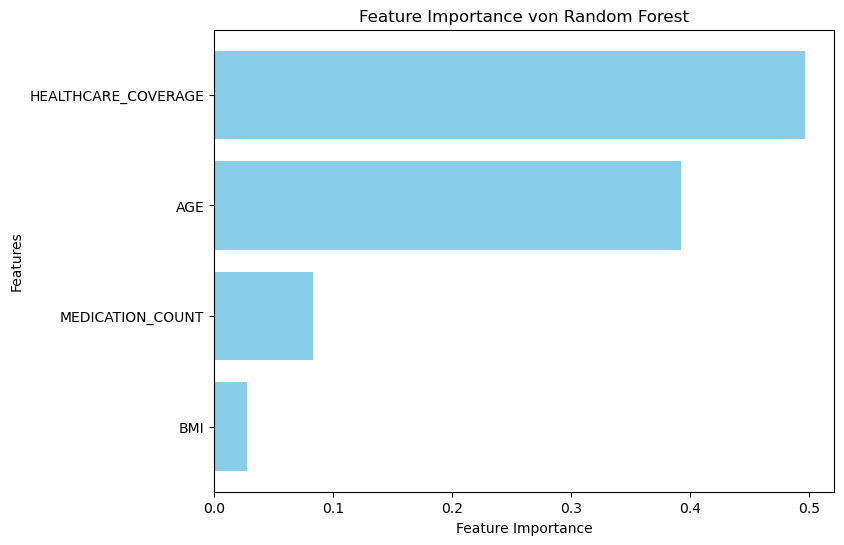

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Optimiertes Random Forest Modell:
Beste Parameter: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Absolute Error: 7012.948957501009
Mean Squared Error: 1213915669.661605
Root Mean Squared Error: 34841.29259458674
R-squared Score: 0.9970178961708743


In [5]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Verbindung zur SQLite-Datenbank herstellen
db_path = "source_allergy.db"
conn = sqlite3.connect(db_path)

# Patienten- und Beobachtungsdaten abrufen
patients_df = pd.read_sql_query("SELECT Id, HEALTHCARE_EXPENSES, HEALTHCARE_COVERAGE, BIRTHDATE FROM patients;", conn)
bmi_values = pd.read_sql_query("SELECT PATIENT, VALUE as BMI FROM observations WHERE CODE = '39156-5';", conn)
medications_count = pd.read_sql_query("SELECT PATIENT, COUNT(*) as MEDICATION_COUNT FROM medications GROUP BY PATIENT;", conn)

# Verbindung schließen
conn.close()

# Alter berechnen
patients_df['BIRTHDATE'] = pd.to_datetime(patients_df['BIRTHDATE'])
patients_df['AGE'] = (pd.to_datetime("today") - patients_df['BIRTHDATE']).dt.days // 365

# Daten zusammenführen
merged_df = patients_df.merge(bmi_values, left_on='Id', right_on='PATIENT', how='left')
merged_df = merged_df.merge(medications_count, left_on='Id', right_on='PATIENT', how='left')
merged_df.fillna({'BMI': merged_df['BMI'].median(), 'MEDICATION_COUNT': 0}, inplace=True)

# Features und Zielvariable definieren
features = ['BMI', 'HEALTHCARE_COVERAGE', 'AGE', 'MEDICATION_COUNT']
X = merged_df[features]
y = merged_df['HEALTHCARE_EXPENSES']

# Daten in Trainings- und Testsets aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Modell trainieren
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Feature Importance analysieren
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Visualisierung der Feature Importance
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance von Random Forest")
plt.gca().invert_yaxis()
plt.show()

# Hyperparameter-Tuning für Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)

# Bestes Modell evaluieren
y_pred = rf_grid_search.best_estimator_.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Optimiertes Random Forest Modell:")
print(f"Beste Parameter: {rf_grid_search.best_params_}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")


Erklärung des Ergebnisses im Medizinischen Kontext
Modelloptimierung und Auswahl der besten Parameter
Das Modell wurde mithilfe eines Grid Search Verfahrens mit 5-facher Kreuzvalidierung optimiert. Das bedeutet:

Das Modell testet 108 verschiedene Kombinationen von Parametern und führt insgesamt 540 Modelltrainings durch.
Das beste Modell wurde mit den folgenden Hyperparametern ausgewählt:
max_depth: None → Keine Begrenzung der Baumtiefe, das Modell kann komplexe Zusammenhänge erfassen.
min_samples_leaf: 1 → Jeder Blattknoten kann bis zu einer einzelnen Beobachtung heruntergebrochen werden.
min_samples_split: 2 → Ein Split wird durchgeführt, sobald mindestens 2 Beobachtungen in einem Knoten vorhanden sind.
n_estimators: 200 → Das Modell verwendet 200 Entscheidungsbäume, um eine robuste Vorhersage zu treffen.
Modellgüte und Fehlermetriken
Das Modell sagt zukünftige Gesundheitsausgaben basierend auf Faktoren wie BMI, Alter, Krankenversicherung und Anzahl der Medikamente vorher.

Mean Absolute Error (MAE): 7.012 USD

Das Modell liegt im Durchschnitt um etwa 7.012 USD daneben.
Ein niedriger MAE bedeutet eine hohe Vorhersagegenauigkeit.
Mean Squared Error (MSE): 1.213 Milliarden USD²

Eine quadratische Fehlergröße, die extrem hohe Abweichungen stärker bestraft.
Ein niedriger MSE bedeutet, dass große Fehler selten vorkommen.
Root Mean Squared Error (RMSE): 34.841 USD

Ein Maß für die durchschnittliche Fehlergröße.
Das Modell hat im Durchschnitt eine Abweichung von ca. 34.841 USD bei den vorhergesagten Gesundheitskosten.
R²-Score: 0.997

Dies bedeutet, dass das Modell 99.7 % der Schwankungen der Gesundheitsausgaben erklären kann.
Ein R²-Wert nahe 1 ist ideal und zeigt, dass das Modell fast perfekt arbeitet.

Medizinische Interpretation
Dieses Modell könnte in der Krankenhausverwaltung oder Versicherungsmathematik eingesetzt werden, um zukünftige Gesundheitsausgaben von Patienten vorherzusagen.

Krankenversicherungen könnten es nutzen, um bessere Tarife für Patienten mit höheren erwarteten Ausgaben festzulegen.
Krankenhäuser und Kliniken könnten damit Budget- und Ressourcenzuweisungen optimieren.
Ärzte könnten es nutzen, um Risikopatienten mit besonders hohen Gesundheitsausgaben frühzeitig zu identifizieren und gezielt präventive Maßnahmen einzuleiten.
Das Modell ist sehr präzise, sollte aber mit weiteren klinischen Parametern (z. B. Vorerkrankungen, Laborwerte) ergänzt werden, um eine noch genauere Vorhersage zu ermöglichen.

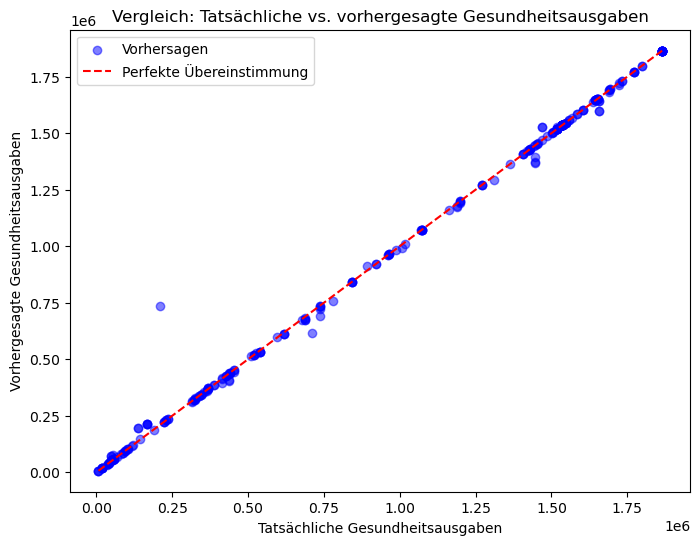

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estim

In [6]:
# Visualisierung der Modellvorhersagen
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Vorhersagen')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='dashed', color='red', label='Perfekte Übereinstimmung')
plt.xlabel("Tatsächliche Gesundheitsausgaben")
plt.ylabel("Vorhergesagte Gesundheitsausgaben")
plt.title("Vergleich: Tatsächliche vs. vorhergesagte Gesundheitsausgaben")
plt.legend()
plt.show()